# ONENOTEBOOK for RASCAL, ROLR, BXE

### Import Modules

In [87]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
from torch.optim import Adam

# distributions
from torch.distributions import Normal

# data generation
from torch.utils.data import Dataset, DataLoader
import numpy as np

# plotting
import matplotlib.pyplot as plt

### Generate Data

#### Dataset

In [88]:
class GoldGenerator(Dataset):
    def __init__(self, generations=100) -> None:
        super().__init__()

        # dataset
        self.dataset = {}

        # num of points and generations
        self.data_points = 100
        self.generations = generations

        # theta hypothesis
        param_size = 1
        theta_0 = 0.0
        theta_1 = 1.0

        # std for data generation
        x_std = 0.1
        z_std = 1.0

        # distributions
        dist_0 = Normal(loc=theta_0, scale=z_std)
        dist_1 = Normal(loc=theta_1, scale=z_std)

        for gen_idx in range(self.generations):

            # target labels and parameter thetas
            theta_0_tensor = torch.zeros(self.data_points)
            theta_1_tensor = torch.ones(self.data_points)
            y = torch.vstack([theta_0_tensor[:int(self.data_points/2)],
                              theta_1_tensor[:int(self.data_points/2)]])

            # empty tensors
            X = torch.empty((self.data_points, 3))
            Y = torch.empty((self.data_points, 3))

            # from theta_0
            z0 = dist_0.rsample((int(self.data_points/2),))

            # from theta_1
            z1 = dist_1.rsample((int(self.data_points/2),))
            Z = torch.vstack([z0, z1])

            # from z0
            x0 = Normal(loc=z0, scale=x_std).rsample((1,))

            # from z1
            x1 = Normal(loc=z1, scale=x_std).rsample((1,))
            x = torch.hstack([x0, x1]).reshape((self.data_points,))
        
            X[:, 0] = x
            X[:, 1] = theta_0_tensor
            X[:, 2] = theta_1_tensor * theta_1  # for paramterization

            # ratio calculation
            r_xz = dist_0.log_prob(Z) - dist_1.log_prob(Z)

            # score calculation
            t_xz = (x - theta_0) / z_std**2


            # targets
            Y[:, 0] = y.reshape((self.data_points,))
            Y[:, 1] = r_xz.reshape((self.data_points,))
            Y[:, 2] = t_xz.reshape((self.data_points,))

            self.dataset[gen_idx] = (X, Y)

    def __len__(self):
        return self.generations

    def __getitem__(self, index):
        return self.dataset[index][0], self.dataset[index][1]


In [89]:
ds = GoldGenerator()
dl = DataLoader(dataset=ds,
                batch_size=16,
                shuffle=True)

### The Model

In [90]:
class Model(pl.LightningModule):
    def __init__(self,
                 regression_type="ROLR") -> None:
        super().__init__()

        # regression type -> "ROLR", "RASCAL", "BXE"
        self.regression_type = regression_type

        if self.regression_type == "RASCAL":
            self.alpha = 0.01

        # total loss on epoch end
        self.total_loss = []
        self.mse = []
        self.epoch_end = False

        # efficiency
        self.efficiency_his = []

        self.net = nn.Sequential(
            nn.Linear(3, 10),
            nn.PReLU(),
            nn.Linear(10, 10),
            nn.PReLU(),
            nn.Linear(10, 10),
            nn.PReLU(),
            nn.Linear(10, 1)
        )

        if self.regression_type == "BCE":
            self.net.append(nn.Sigmoid())

    def forward(self, x):
        output = self.net(x)
        return output

    def configure_optimizers(self):
        optim = Adam(self.parameters())
        return optim

    def training_step(self, train_batch, batch_idx):
        X, Y = train_batch

        # unpack Y
        targets, ratio, score = Y[:, :, 0].view(-1), Y[:, :, 1].view(-1).exp(), Y[:, :, 2].view(-1)

        # loss function
        if self.regression_type =="BCE":
            y_hat = self.net(X).view(-1)
            loss = nn.functional.binary_cross_entropy(torch.squeeze(y_hat, -1),targets)

        
        if self.regression_type in ["RASCAL", "ROLR"]:
            # output of the model
            ratio_hat = self.net(X).view(-1).exp()

            loss = torch.mean(targets * (
                ratio - ratio_hat)**2 + (1-targets) * (1/ratio - 1/ratio_hat)**2)
        
            if self.regression_type == "RASCAL":
                loss += self.alpha * torch.mean((1-targets)*(score - torch.autograd.functional.jvp(self.net, X, torch.ones_like(X))[1])**2)
            
        self.log("train_loss", loss)

        if self.epoch_end is True:
            self.total_loss.append(loss.detach().numpy())
            self.epoch_end = False

            x = torch.linspace(-0.5, 1.5, 1000)
            theta0 = torch.zeros_like(x)
            theta1 = torch.ones_like(x)

            X = torch.vstack([x, theta0, theta1]).T

            output = self.net(X).detach().numpy()

            if self.regression_type == "BCE":
                output = np.log((1-output)/output)
            
            true_llr = self.calculate_likelihood_ratio(x, 0.0, 1.0)
                
            self.mse.append(np.mean((output.reshape((1000,)) - true_llr.detach().numpy())**2))

        return loss

    def on_epoch_end(self):
        # toggle epoch end for easy loss display
        self.epoch_end = True
            
        return
    
    def calculate_likelihood_ratio(self, x, theta0, theta1):
        combined_std = (1.0**2 + 0.1**2) ** 0.5
        r_x = Normal(loc=theta0, scale=combined_std).log_prob(x) - Normal(loc=theta1, scale=combined_std).log_prob(x)
        return r_x


### ROLR

In [91]:
model_rolr = Model(regression_type="ROLR")
trainer = pl.Trainer(max_epochs=200)
trainer.fit(model=model_rolr,
            train_dataloaders=dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:307: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 274   
------------------------------------
274       Trainable params
0         Non-trainable params
274       Total params
0.001     Total estimated model params size (MB)
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` arg

Training: 0it [00:00, ?it/s]

#### Output

In [92]:
def calculate_likelihood_ratio(x, theta0, theta1):
    combined_std = (1.0**2 + 0.1**2) ** 0.5
    r_x = Normal(loc=theta0, scale=combined_std).log_prob(x) - Normal(loc=theta1, scale=combined_std).log_prob(x)
    return r_x

In [93]:
def gen_events(number_of_points, theta0=0.0, theta1=1.0):
    z0 = Normal(loc=theta0, scale=1.0).rsample((number_of_points,))
    z1 = Normal(loc=theta1, scale=1.0).rsample((number_of_points,))

    x0 = Normal(loc=z0, scale=0.1).rsample((1,))
    x1 = Normal(loc=z1, scale=0.1).rsample((1,))

    return x0, z1

In [94]:
def centralize_bins(bins):
    return (bins[1:] + bins[:-1])/2

0.6554242


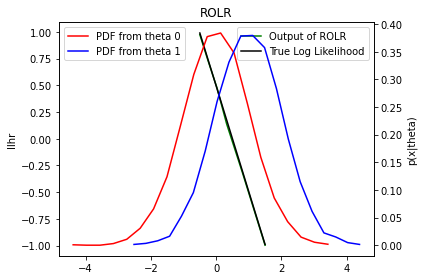

In [95]:
x = torch.linspace(-0.5, 1.5, 1000)
theta0 = torch.zeros_like(x)
theta1 = torch.ones_like(x)

x0, x1 = gen_events(10000)

hist0, bins0 = torch.histogram(x0, bins=20, density=True)
hist1, bins1 = torch.histogram(x1, bins=20, density=True)
cbins0 = centralize_bins(bins0)
cbins1 = centralize_bins(bins1)


X = torch.vstack([x, theta0, theta1]).T

output_rolr = model_rolr(X).detach().numpy()
true_llr = calculate_likelihood_ratio(x, 0.0, 1.0)

print(np.mean((output_rolr-true_llr.detach().numpy())**2))


fig, ax1 = plt.subplots()


ax1.plot(x, output_rolr, "g",label="Output of ROLR")
ax1.plot(x, true_llr, "k",label="True Log Likelihood")

ax1.legend(loc=1)

ax2 = ax1.twinx()

ax2.plot(cbins0, hist0, "r",label="PDF from theta 0")
ax2.plot(cbins1, hist1, "b",label="PDF from theta 1")

ax2.legend(loc=2)
plt.xlabel("x")
ax1.set_ylabel("llhr")
ax2.set_ylabel("p(x|theta)")
plt.title("ROLR")
fig.tight_layout()

### RASCAL

In [96]:
model_rascal = Model(regression_type="RASCAL")
trainer = pl.Trainer(max_epochs=200)
trainer.fit(model=model_rascal,
            train_dataloaders=dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:307: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 274   
------------------------------------
274       Trainable params
0         Non-trainable params
274       Total params
0.001     Total estimated model params size (MB)
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` arg

Training: 0it [00:00, ?it/s]

#### Output


0.65612113


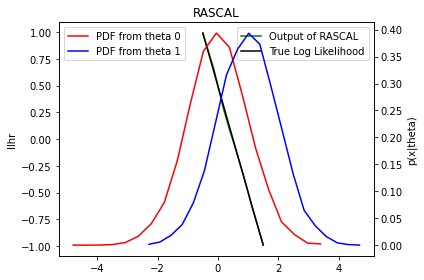

In [97]:
x = torch.linspace(-0.5, 1.5, 1000)
theta0 = torch.zeros_like(x)
theta1 = torch.ones_like(x)

x0, x1 = gen_events(10000)

hist0, bins0 = torch.histogram(x0, bins=20, density=True)
hist1, bins1 = torch.histogram(x1, bins=20, density=True)
cbins0 = centralize_bins(bins0)
cbins1 = centralize_bins(bins1)

print()

X = torch.vstack([x, theta0, theta1]).T

output_rascal = model_rascal(X).detach().numpy()
true_llr = calculate_likelihood_ratio(x, 0.0, 1.0)

print(np.mean((output_rascal-true_llr.detach().numpy())**2))

fig, ax1 = plt.subplots()


ax1.plot(x, output_rascal, "g",label="Output of RASCAL")
ax1.plot(x, true_llr, "k",label="True Log Likelihood")

ax1.legend(loc=1)

ax2 = ax1.twinx()

ax2.plot(cbins0, hist0, "r",label="PDF from theta 0")
ax2.plot(cbins1, hist1, "b",label="PDF from theta 1")

ax2.legend(loc=2)
plt.xlabel("x")
ax1.set_ylabel("llhr")
ax2.set_ylabel("p(x|theta)")
plt.title("RASCAL")
fig.tight_layout()

### Normal (BXE)

In [98]:
model_bce = Model(regression_type="BCE")
trainer = pl.Trainer(max_epochs=200)
trainer.fit(model=model_bce,
            train_dataloaders=dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:307: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 274   
------------------------------------
274       Trainable params
0         Non-trainable params
274       Total params
0.001     Total estimated model params size (MB)
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` arg

Training: 0it [00:00, ?it/s]


0.6957049


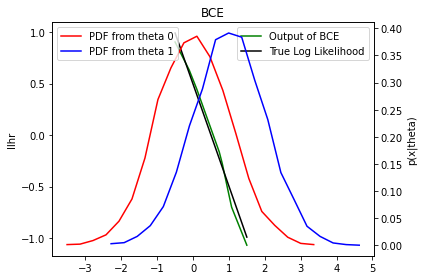

In [99]:
x = torch.linspace(-0.5, 1.5, 1000)
theta0 = torch.zeros_like(x)
theta1 = torch.ones_like(x)

x0, x1 = gen_events(10000)

hist0, bins0 = torch.histogram(x0, bins=20, density=True)
hist1, bins1 = torch.histogram(x1, bins=20, density=True)
cbins0 = centralize_bins(bins0)
cbins1 = centralize_bins(bins1)

print()

X = torch.vstack([x, theta0, theta1]).T

output_bce = model_bce(X).detach().numpy()
llr = np.log((1-output_bce)/output_bce)
true_llr = calculate_likelihood_ratio(x, 0.0, 1.0)

print(np.mean((llr-true_llr.detach().numpy())**2))


fig, ax1 = plt.subplots()


ax1.plot(x, llr, "g",label="Output of BCE")
ax1.plot(x, true_llr, "k",label="True Log Likelihood")

ax1.legend(loc=1)

ax2 = ax1.twinx()

ax2.plot(cbins0, hist0, "r",label="PDF from theta 0")
ax2.plot(cbins1, hist1, "b",label="PDF from theta 1")

ax2.legend(loc=2)
plt.xlabel("x")
ax1.set_ylabel("llhr")
ax2.set_ylabel("p(x|theta)")
plt.title("BCE")
fig.tight_layout()

#### ROLR vs. RASCAL vs. Normal BXE

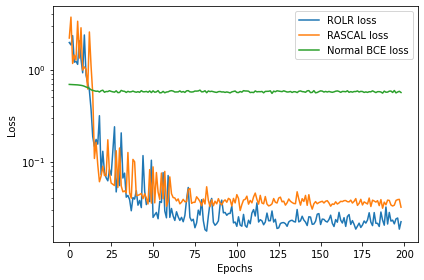

In [100]:
plt.plot(model_rolr.total_loss, label="ROLR loss")
plt.plot(model_rascal.total_loss, label="RASCAL loss")
plt.plot(model_bce.total_loss, label="Normal BCE loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.semilogy()
plt.legend()
plt.tight_layout()

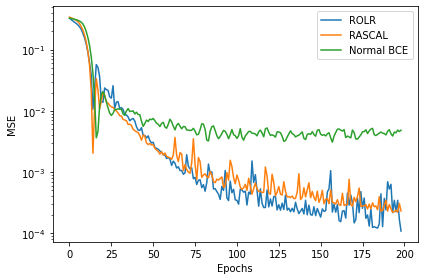

In [105]:
plt.plot(model_rolr.mse, label="ROLR ")
plt.plot(model_rascal.mse, label="RASCAL ")
plt.plot(model_bce.mse, label="Normal BCE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.semilogy()
plt.legend()
plt.tight_layout()

### Likelihood Ratios

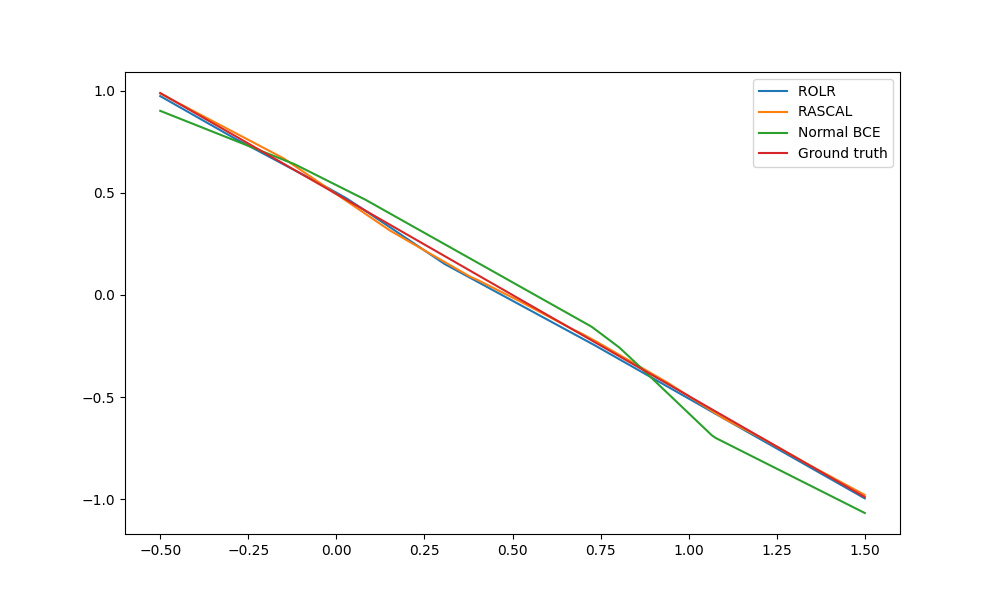

In [108]:
%matplotlib widget
plt.figure(figsize=(10,6))
plt.plot(x, output_rolr, label="ROLR ")
plt.plot(x, output_rascal, label="RASCAL ")
plt.plot(x, llr, label="Normal BCE")
plt.plot(x, true_llr, label="Ground truth")
plt.legend()
plt.show()